In [9]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [10]:
!pip install jitcdde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.1/164.1 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 25.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for jitcdde: filename=jitcdde-1.8.1-py3-none-any.whl size=55003 sha256=2fc18b6265c468e38270dbfbd951083abb908ed5fd7a5cc45a1d8dfbf4a22606
  Stored in directory: /root/.cache/pip/wheels/42/e3/4e/94b61188e5e3e62ba27e9586da5ecc7ea0f24e26916a250cc7
  Created wheel for chspy: filename=CHSPy-1.2.2-py3-none-any.whl size=11999 sha256=24b7bdad73e0c283fb02b70ea314f2f9c553b34fd878268827f8565209089e07
  Stored in directory: /root/.cache/pip/wheels/11/17/24/0cca70842afd051f54325b813e637d8e8836d88c286ba63fae
  Created wheel for jitcxde_common: filename=jitcxde_common-1.5.4-py3-none-any.whl size=16755 sha256=a35e5b9568544953e79ffbb42a8250f4fce9ed9f265bb9db8b699cf8a9380ba4
  Stored in directory: /root/.cach

In [11]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from jitcdde import jitcdde, y, t
from numpy import pi, arange, random, max
import symengine
from scipy.signal import welch
from tqdm import tqdm
import os

In [12]:
weight_filename = "gdrive/MyDrive/PBM-report2/WeightedA33.dat"
# mapping_filename = "gdrive/MyDrive/PBM-report2/Categorized_Brain_Nodes.csv"
mapping_filename = "gdrive/MyDrive/PBM-report2/Y_Categorized_Brain_Nodes.csv"
fiber_length_filename = "gdrive/MyDrive/PBM-report2/LengthFibers33.dat"

w_kj = np.loadtxt(weight_filename)
num_nodes = w_kj.shape[0]

In [18]:
# Define the differential equation model
def dcdt(c_k, q_k, w_kj, alpha):
    # Define the graph Laplacian matrix L
    D = np.diag(w_kj.sum(axis=1))
    L = rho * (D - w_kj)
    return -L.dot(c_k) + alpha * c_k * (1 - c_k)

def dqdt(c_k, q_k, beta):
    return beta * c_k * (1 - q_k)

def dwdt(w_kj, q_k, gamma):
    q_sum = q_k[:, None] + q_k  # Calculate the sum of damage
    return -gamma * w_kj * q_sum

# Integrate the model equations
def model(y, t, beta, gamma):
    num_variables = 2 * num_nodes + num_nodes**2
    c_k = y[:num_nodes]
    q_k = y[num_nodes:2*num_nodes]
    w_kj = y[2*num_nodes:num_variables].reshape((num_nodes, num_nodes))

    # Calculate dc/dt, dq/dt, dw/dt
    dc_dt = dcdt(c_k, q_k, w_kj, alpha)
    dq_dt = dqdt(c_k, q_k, beta)
    dw_dt = dwdt(w_kj, q_k, gamma).flatten()

    # Merge them back into a flat array
    dydt = np.concatenate((dc_dt, dq_dt, dw_dt))
    return dydt

0.24664643942331504
[ 0.          1.03448276  2.06896552  3.10344828  4.13793103  5.17241379
  6.20689655  7.24137931  8.27586207  9.31034483 10.34482759 11.37931034
 12.4137931  13.44827586 14.48275862 15.51724138 16.55172414 17.5862069
 18.62068966 19.65517241 20.68965517 21.72413793 22.75862069 23.79310345
 24.82758621 25.86206897 26.89655172 27.93103448 28.96551724 30.        ]


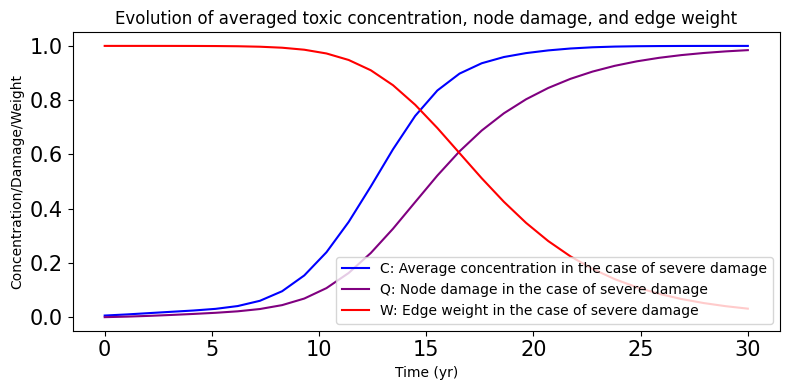

In [19]:
# Initialize c_k (toxic protein concentration), q_k (node damage), and w_kj (edge weight)
c_k = np.zeros(num_nodes)
q_k = np.zeros(num_nodes)

# seed_protein_concentration = 0.025
seed_protein_concentration = np.random.normal(0.25, 0.01)
print(seed_protein_concentration)

# Define model parameters
alpha = 0.75  # 3/4 per year
beta_severe = 1 / 4
gamma_severe = 1 / 8
rho = 1 / 100  # mm/yr, Laplacian rate constant

# Assume that the node indexes corresponding to the medial frontal area are 26 and 68
entorhinal_nodes = [26, 68]
for entorhinal_node in entorhinal_nodes:
    c_k[entorhinal_node-1] = seed_protein_concentration

np.random.seed(42)

# Set the time points
transport_times = np.linspace(0, 30, 30) # From 0 to 30 years, a total of 1000 time points
print(transport_times)
# Set initial conditions
y0 = np.concatenate((c_k, q_k, w_kj.flatten()))

# Severe damage (β=1/4, γ=1/8)
sol_severe = odeint(model, y0, transport_times, args=(beta_severe, gamma_severe))
c_k_severe = sol_severe[:, :num_nodes]
q_k_severe = sol_severe[:, num_nodes:2*num_nodes]
w_kj_severe = sol_severe[:, 2*num_nodes:].reshape((len(transport_times), num_nodes, num_nodes))
C_T_severe = c_k_severe.mean(axis=1)
Q_severe = q_k_severe.mean(axis=1)
W_severe = np.array([np.linalg.norm(w) / np.linalg.norm(w_kj) for w in w_kj_severe])

# Plot the results
plt.figure(figsize=(8, 4))
plt.plot(transport_times, C_T_severe, 'b-', label='C: Average concentration in the case of severe damage')
plt.plot(transport_times, Q_severe, color="purple", label='Q: Node damage in the case of severe damage')
plt.plot(transport_times, W_severe, 'r-', label='W: Edge weight in the case of severe damage')
plt.title('Evolution of averaged toxic concentration, node damage, and edge weight')
plt.xlabel('Time (yr)')
plt.ylabel('Concentration/Damage/Weight')
plt.legend()
plt.tight_layout()
plt.show()

In [35]:
tau_kj = np.loadtxt(fiber_length_filename)
tau_kj = tau_kj/1500

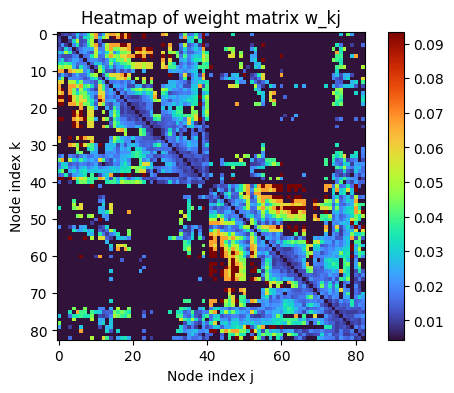

In [36]:
# We flatten the array for the qcut function and then reshape it back to the original shape.
discretized_data, bins = pd.qcut(tau_kj.ravel(), 40, retbins=True, labels=False, duplicates='drop')

# Calculate the mean of the bins
bin_means = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins) - 1)]

# Map discretized data to the mean of the interval
discretized_tau_kj = np.array([bin_means[i] for i in discretized_data])
discretized_tau_kj = discretized_tau_kj.reshape(tau_kj.shape)

# Plotting the heatmap
plt.figure(figsize=(6, 4))
heatmap = plt.imshow(discretized_tau_kj, cmap='turbo')
plt.colorbar(heatmap)
plt.title('Heatmap of weight matrix w_kj')
plt.xlabel('Node index j')
plt.ylabel('Node index k')
plt.show()

In [10]:
def sigmoid(x):
    return 1 / (1 + symengine.exp(-x))

def rsd_model(w_kj):
  n = num_nodes
  mean_omega = 40
  variance_omega = 0.1
  ω = np.random.normal(mean_omega, np.sqrt(variance_omega), n)
  λ = -0.01
  A = w_kj
  τ = discretized_tau_kj
  k = 10

  def resting_state_model():
    for i in range(num_nodes):
      # calculate the coupling sum for excitatory population
      coupling_sum = sum( A[i,j]*y(2*j, t-τ[i,j]) for j in range(num_nodes) )
      # apply the sigmoid functuon to the coupling term
      coupling_term = sigmoid(coupling_sum)

      # Excitatory population equation
      yield λ * y(2*i) - ω[i]*y(2*i+1) - y(2*i) * (y(2*i)**2 + y(2*i+1)**2) + k*coupling_term

      # Inhibitory population equation
      yield λ * y(2*i+1) + ω[i]*y(2*i) - y(2*i+1) * (y(2*i)**2 + y(2*i+1)**2)

  I = jitcdde(resting_state_model,n=2*n,verbose=False,delays=τ.flatten())
  I.set_integration_parameters(rtol=0,atol=1e-5)

  I.constant_past( np.random.rand(n*2), time=0.0 )
  I.integrate_blindly( max(τ) , 0.01 )

  # Time span for integration (10 seconds)
  t_end = 12
  dt = 0.01  # Adjust dt to the desired time resolution
  times = np.arange(2, t_end, dt)
  data = np.zeros((len(times), n*2))  # Pre-allocate space for efficiency

  # for time in I.t + arange(0,10,0.01):
  #   print(I.integrate(time))

  # Integrate and store the data
  for i, time in enumerate(times):
      data[i] = I.integrate(time)

  exc = data[:,:83]
  inh = data[:,83:]
  return exc, inh, dt, times, ω

In [13]:
def load_node_categories(filepath):
    node_data = pd.read_csv(filepath)
    node_data['Node'] = node_data['Node'] - 1
    node_groups = node_data.groupby('new_Super_Region')['Node'].apply(list).to_dict()
    return node_groups

In [12]:
def compute_biomarkers(excitatory, inhibitory, dt, omega, node_groups, nperseg=None):
  fs = 1/dt
  z = excitatory + 1j * inhibitory
  results = {}

  omega = np.sort(omega)

  # Compute global metrics
  global_avg_z = np.mean(z, axis=1)
  f, global_psd = welch(global_avg_z, fs=fs, nperseg=nperseg)
  global_interpolated_psd = np.interp(omega, f, global_psd)
  global_PT = np.trapz(global_interpolated_psd, omega)
  global_AT = np.mean(np.trapz(np.abs(z), dx=1/fs, axis=0))
  global_BT = np.mean(np.var(np.abs(z), axis=0))
  results['global'] = (global_PT, global_AT, global_BT)

  # Compute metrics per region
  for region, nodes in node_groups.items():
    region_z = np.mean(z[:, nodes], axis=1)
    f, region_psd = welch(region_z, fs=fs, nperseg=nperseg)
    region_interpolated_psd = np.interp(omega, f, region_psd)
    region_PT = np.trapz(region_interpolated_psd, omega)
    region_AT = np.mean(np.trapz(np.abs(z[:,nodes]), dx=1/fs, axis=0))
    region_BT = np.mean(np.var(np.abs(z[:, nodes]), axis=0))
    results[region] = (region_PT, region_AT, region_BT)

  return results

In [13]:
def run_simulation(w_kj, save_path, node_groups):
    # Initialize dictionaries to hold all region metrics including global dynamic biomarkers
    region_metrics = {region: {'pt': [], 'at': [], 'bt': []} for region in node_groups}
    region_metrics['global'] = {'pt': [], 'at': [], 'bt': []}

    # Loop through weight after each year of disease progression and simulate the resting state dynamics
    for w in tqdm(w_kj, desc="Simulation Progress"):
        exc, inh, dt, times, omega = rsd_model(w)
        all_region_metrics = compute_biomarkers(exc, inh, dt, omega, node_groups)

        # Store metrics for 'global' and specified regions
        for region in all_region_metrics:
            region_metrics[region]['pt'].append(all_region_metrics[region][0])
            region_metrics[region]['at'].append(all_region_metrics[region][1])
            region_metrics[region]['bt'].append(all_region_metrics[region][2])

    # Append the biomarkers for all regions to files
    for region, metrics in region_metrics.items():
        file_path = os.path.join(save_path, f'dynamic_biomarkers_{region}.npy')
        new_data = np.array([metrics['pt'], metrics['at'], metrics['bt']])

        # Check if file exists and load existing data
        if os.path.exists(file_path):
            existing_data = np.load(file_path, allow_pickle=True)
            combined_data = np.concatenate((existing_data, new_data), axis=1)  # Concatenate along the second dimension
        else:
            combined_data = new_data

        # Save the updated data
        np.save(file_path, combined_data)

    return region_metrics

In [17]:
# def scale_weights(w_kj_severe, xi):
#     """
#     Apply homeostasis adaptation to the weight matrix as per the provided formula.

#     Parameters:
#     w_kj_severe (numpy.ndarray): 3D array of shape (timepoints, nodes, nodes) representing the weight matrices over time.
#     xi (float): Homeostasis parameter within [0, 1].

#     Returns:
#     numpy.ndarray: Scaled weights.
#     """
#     # Initialize the array for the scaled weights
#     scaled_w_kj_severe = np.zeros_like(w_kj_severe)

#     # Set the first timepoint to be the same as in w_kj_severe
#     scaled_w_kj_severe[0] = w_kj_severe[0]

#     # Apply scaling for each subsequent timepoint
#     for T in range(1, len(w_kj_severe)):
#         norm_W_T = np.linalg.norm(w_kj_severe[T])
#         norm_W_T_minus_1 = np.linalg.norm(w_kj_severe[T - 1])
#         scaled_w_kj_severe[T] = ((1 - xi) + xi * (norm_W_T_minus_1 / norm_W_T)) * w_kj_severe[T]

#     return scaled_w_kj_severe

In [42]:
node_groups = load_node_categories(mapping_filename)
all_region_metrics = {region: {'pt':[], 'at':[], 'bt':[]} for region in node_groups}
all_region_metrics['global'] = {'pt': [], 'at': [], 'bt': []}

number_of_realizations = 1

# Run simulation and save data
for realization_index in range(number_of_realizations):
    region_metrics = run_simulation(w_kj_severe, 'gdrive/MyDrive/PBM-report2/v4', node_groups)

    # Accumulate metrics across all realizations
    for region, metrics in region_metrics.items():
        for metric_type in ['pt', 'at', 'bt']:
            all_region_metrics[region][metric_type].extend(metrics[metric_type])

Simulation Progress:   0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/scipy/signal/_spectral_py.py:1870: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '
Simulation Progress: 100%|██████████| 30/30 [35:19<00:00, 70.65s/it]


In [14]:
def calculate_statistics(number_of_realizations, all_region_metrics):
    stats = {}
    for region, metrics in all_region_metrics.items():
        stats[region] = {}
        for metric_type in ['pt', 'at', 'bt']:
            metric_data = np.array(metrics[metric_type]).reshape((number_of_realizations, len(transport_times)))
            # if metric_type=='pt':
              # print(metric_data)
            # normalized_metric_data = metric_data
            normalized_metric_data = metric_data / metric_data[:,0].reshape(-1,1)
            mean = np.mean(normalized_metric_data, axis=0)
            std = np.std(normalized_metric_data, axis=0)
            stats[region][metric_type] = (mean, std)
    return stats

def plot_statistics(stats):
    # Define colors for each region specifically
    region_colors = {
        'basal_ganglia': 'violet',
        'limbic': 'darkblue',
        'temporal': 'skyblue',
        'occipital': 'green',
        'parietal': 'orange',
        'frontal': 'red',
        'global': 'black'
    }

    # Metric names to be plotted
    metric_names = ['PT', 'AT', 'BT']

    # Create a figure with subplots
    fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

    # Plot each metric in a separate subplot
    for i, metric in enumerate(metric_names):
        ax = axes[i]
        for region in stats.keys():
          if region in region_colors:  # Check if the color is defined for the region
            mean, std = stats[region][metric.lower()]  # Only using 'at' as metric
            line_width = 2 if region == 'global' else 1
            ax.errorbar(transport_times, mean, yerr=std, fmt='-', label=region,
                        color=region_colors.get(region), ecolor=region_colors.get(region),
                        capsize=2, elinewidth=0.5, linewidth=line_width)

        # ax.set_title(f'{metric} Across Realizations')
        ax.set_xlabel('Time T (yr)', fontsize=15)
        ax.set_ylabel(f'{metric} Value', fontsize=15)
        ax.plot(transport_times, C_T_severe, alpha=0.2, linewidth=3.5, color='gray')

        # if metric == 'PT':
        #   ax.set_ylim(0, 2)
        # Only add legend to the AT plot
        if metric == 'AT':
            ax.legend(loc='center left', fontsize=15)
        if metric == 'BT':
          ax.set_ylim(0, 5)

    plt.tight_layout()
    plt.show()

In [15]:
import matplotlib
matplotlib.rc('xtick', labelsize=15)
matplotlib.rc('ytick', labelsize=15)

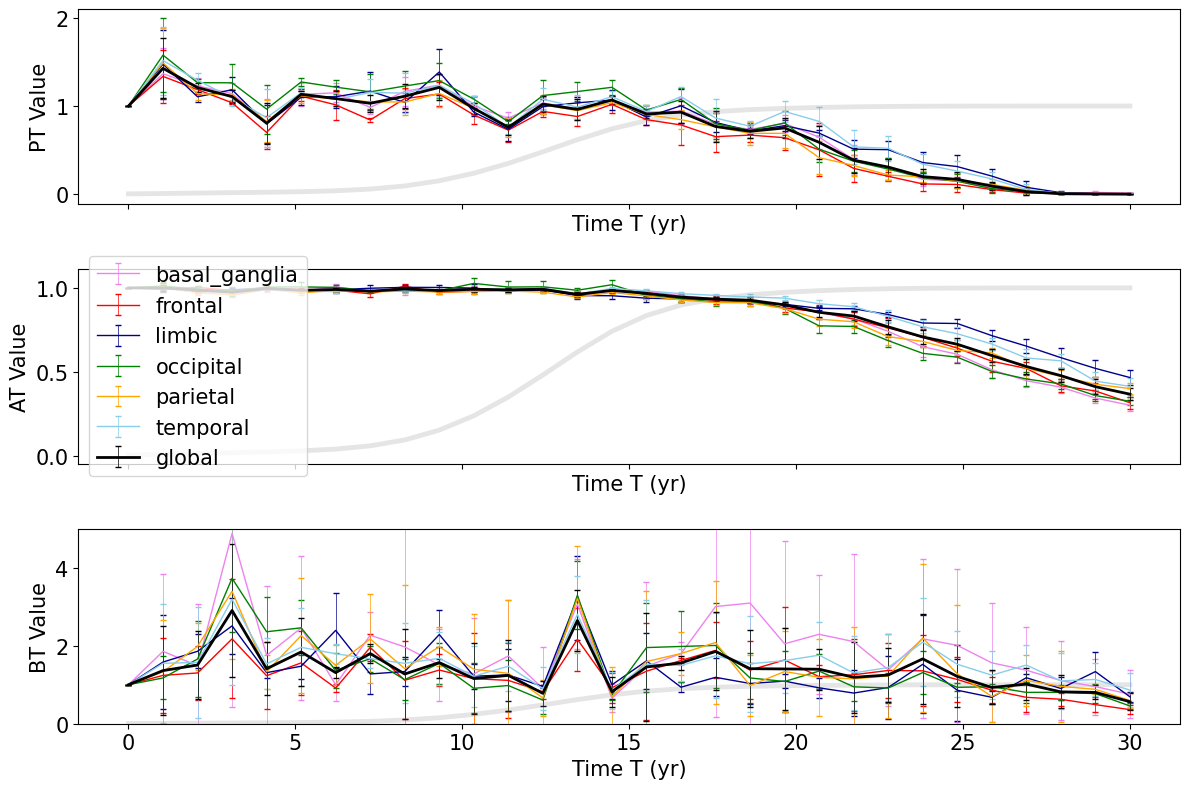

In [20]:
# Calculate statistics
stats = calculate_statistics(6, all_region_metrics)

# Plot statistics
plot_statistics(stats)

In [23]:
file_path = os.path.join(save_path, f'dynamic_biomarkers_limbic.npy')
with open(file_path, 'rb') as f:
  data = np.load(f, allow_pickle=True)

In [24]:
data[2]

array([0.04090813, 0.04206932, 0.06905666, 0.08806386, 0.05739972,
       0.05380924, 0.1255426 , 0.04182147, 0.04478913, 0.10923321,
       0.04603399, 0.03661609, 0.0386036 , 0.15003553, 0.03121003,
       0.05543385, 0.0372221 , 0.03595323, 0.03358778, 0.04409657,
       0.03210928, 0.02514755, 0.0168936 , 0.03468649, 0.021685  ,
       0.0281211 , 0.05481571, 0.03421752, 0.08724888, 0.03026217,
       0.04059513, 0.04438982, 0.11446132, 0.16671907, 0.05020941,
       0.05639678, 0.02417656, 0.04787384, 0.08426426, 0.08456809,
       0.04094077, 0.05006837, 0.0403899 , 0.03255602, 0.04508982,
       0.12911417, 0.04955719, 0.07801662, 0.0891621 , 0.057797  ,
       0.05958934, 0.01748022, 0.09345194, 0.09130806, 0.03044623,
       0.0230382 , 0.05176863, 0.02312342, 0.02423246, 0.03838616,
       0.03672308, 0.15727078, 0.05781564, 0.08611137, 0.03763085,
       0.08158806, 0.05748271, 0.08934043, 0.05773041, 0.03605114,
       0.07121598, 0.09968874, 0.03623131, 0.1416027 , 0.06496

In [16]:
def load_and_aggregate_metrics(save_path, node_groups):
    all_region_metrics = {region: {'pt': [], 'at': [], 'bt': []} for region in node_groups}
    all_region_metrics['global'] = {'pt': [], 'at': [], 'bt': []}  # Ensure 'global' is included

    # Iterate through each region
    for region in all_region_metrics.keys():
        file_path = os.path.join(save_path, f'dynamic_biomarkers_{region}.npy')

        # Check if the file exists
        if os.path.exists(file_path):
            # Load the file
            with open(file_path, 'rb') as f:
                data = np.load(f, allow_pickle=True)
                print(data.shape[1])
            # Assuming data is structured as a list of arrays for pt, at, bt
            if data.shape[0] == 3:  # Ensure data is correctly formatted
                all_region_metrics[region]['pt'] = data[0].tolist()
                all_region_metrics[region]['at'] = data[1].tolist()
                all_region_metrics[region]['bt'] = data[2].tolist()

    return all_region_metrics

node_groups = load_node_categories(mapping_filename)
save_path = 'gdrive/MyDrive/PBM-report2/v4'

# Load and aggregate metrics
all_region_metrics = load_and_aggregate_metrics(save_path, node_groups)

180
180
180
180
180
180
180
180


In [ ]:
node_groups = load_node_categories(mapping_filename)
all_region_metrics = {region: {'pt':[], 'at':[], 'bt':[]} for region in node_groups}
all_region_metrics['global'] = {'pt': [], 'at': [], 'bt': []}

number_of_realizations = 1

# Run simulation and save data
for realization_index in range(number_of_realizations):
    region_metrics = run_simulation(w_kj_severe, 'gdrive/MyDrive/PBM-report2/v4', node_groups)

    # Accumulate metrics across all realizations
    for region, metrics in region_metrics.items():
        for metric_type in ['pt', 'at', 'bt']:
            all_region_metrics[region][metric_type].extend(metrics[metric_type])

In [ ]:
f = 'gdrive/MyDrive/PBM-report2/v4/dynamic_biomarkers_global.npy'
data = np.load(f)
data.shape

(3, 10)

In [ ]:
data[1].reshape(4, 30)

array([[12.41223473, 12.53729987, 12.27782086, 12.15398323, 12.41603154,
        12.30496227, 12.27915475, 12.15360227, 12.44175893, 12.24377095,
        12.47642066, 12.37816892, 12.43197082, 11.99437669, 12.36636074,
        12.22391732, 11.84677318, 11.72932618, 11.77987315, 11.53469408,
        11.01428158, 10.96694231,  9.99664369,  9.44695443,  9.02035475,
         8.0076599 ,  7.18024732,  6.67780408,  5.64351266,  4.96912498],
       [12.54700074, 12.35895044, 12.25726485, 11.95500238, 12.33485344,
        12.40237162, 12.59094171, 12.39102086, 12.4598847 , 12.33409992,
        12.30456166, 12.45394021, 12.27962961, 12.35816854, 12.36797843,
        11.73619996, 12.0185081 , 11.72374178, 11.64186835, 11.302208  ,
        10.99262575, 10.56780098, 10.23091083,  9.44996452,  8.69129741,
         7.96057561,  6.94814229,  6.30538135,  5.73714023,  5.13185746],
       [12.221045  , 12.47705419, 12.29699065, 12.52589752, 12.10131041,
        12.41462669, 12.37693349, 12.14683596, 12

In [ ]:
new_data = np.ones((1,20))
combined_data = np.concatenate((data, new_data), axis=1)
combined_data.shape

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 3 and the array at index 1 has size 1